# torch-autograd example

In this example we show how to train a model without torch nn layers.
We define an arbitrary function using `torch.` operators, which are automatically differentiated
into a neural network model. This is useful in case of complicated models, or 2-nd order derivatives needed.
In the end we will do t-SNE embedding of the learned features.

The notebook can run without GPU support and needs the following rocks:

```
luarocks install autograd
luarocks install mnist
luarocks install manifold
```

In [19]:
-- normally we would avoid having global variables
-- but local variables live only in one cell

grad = require 'autograd'       -- automatic differentiation 
mnist = require 'mnist'         -- MNIST dataset loader
manifold = require 'manifold'   -- for t-SNE embeddings
optim = require 'optim'

grad.optimize(true) -- will make autograd optimize graphs by default

In [3]:
-- define all parameters in this structure
opt = {
   learningRate = 1e-1,
   learningRateDecayRatio = 0.1,
   momentum = 0.9,
   weightDecay = 0.0005,
   dampening = 0,
   type = 'float',
   batchSize = 128,
}

In [4]:
function LinearParams(ni,no)
   local stdv = 1/math.sqrt(no); 
   return {torch.randn(no,ni):uniform(-stdv,stdv), torch.zeros(no)} 
end

function Linear(params, x)
   local W,b = params[1], params[2]
   local y = x * torch.transpose(W,1,2)
   return y + torch.expandAs(b:view(1,b:size(1)), y)
end

cast = function(x) return grad.util.cast(x, opt.type); end

params = cast{
    LinearParams(28*28,512),
    LinearParams(512,64),
    LinearParams(64,10), 
}

local relu = function(x) return torch.cmax(x,0) end

f = function(W, x)
   local output = x:view(-1,28*28)
   for i,w in ipairs(W) do
      output = Linear(w, i == 1 and output or relu(output))
   end
   return output
end

h = function(W, x, y_hat)
   local y = f(W, x)
   return grad.loss.crossEntropy(y, y_hat) / y:size(1)
end

## Prepare data and show a few examples

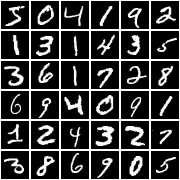

In [5]:
trainData = cast(mnist.traindataset())
testData = cast(mnist.testdataset())

-- simply normalize range to [0,1] range
trainData.label:add(1); trainData.data:div(256)
testData.label:add(1);  testData.data:div(256)

-- show a few examples from the training set
itorch.image(trainData.data:narrow(1,1,36))

In [20]:
local g = grad.optim.sgd(grad(h), grad.util.deepCopy(opt), params)

function train()
    local targets = cast(torch.Tensor(opt.batchSize,10))
    local inputs = cast(torch.Tensor(opt.batchSize,28*28))
    local indices = torch.randperm(trainData.data:size(1)):long():split(opt.batchSize)
    indices[#indices] = nil

    local loss = 0
    for t,v in ipairs(indices) do
        local inputs_ = trainData.data:index(1,v)
        local target_idx = trainData.label:index(1,v)
        targets:zero():scatter(2,target_idx:long():view(opt.batchSize,1),1)
        inputs:copy(inputs_)

        local grads,l = g(inputs, targets)
        loss = loss + l
    end
    return loss
end

function test()
    local confusion = optim.ConfusionMatrix(10)
    local inputs_split = testData.data:split(opt.batchSize)
    local targets_split = testData.label:split(opt.batchSize)
    
    for i,v in ipairs(inputs_split) do
        confusion:batchAdd(f(params, v), targets_split[i])
    end
    print(confusion)
end

In [21]:
local Plot = require 'itorch.Plot'

local nEpochs = 20

local losses = {}
for i=1,nEpochs do
    print('Epoch: '..i)
    table.insert(losses, {train()})
end

local plot = Plot()
plot:line(torch.range(1,#losses), torch.Tensor(losses):select(2,2))
plot:draw()

Epoch: 1	


Epoch: 2	


Epoch: 3	


Epoch: 4	


Epoch: 5	


Epoch: 6	


Epoch: 7	


Epoch: 8	


Epoch: 9	


Epoch: 10	


Epoch: 11	


Epoch: 12	


Epoch: 13	


Epoch: 14	


Epoch: 15	


Epoch: 16	


Epoch: 17	


Epoch: 18	


Epoch: 19	


Epoch: 20	


[string "local Plot = require 'itorch.Plot'..."]:12: bad argument #2 to 'select' (out of range at /tmp/torch7/lib/TH/generic/THTensor.c:370)
stack traceback:
	[C]: in function 'select'
	[string "local Plot = require 'itorch.Plot'..."]:12: in main chunk
	[C]: in function 'xpcall'
	...s/szagoruyko/torch/install/share/lua/5.1/itorch/main.lua:209: in function <...s/szagoruyko/torch/install/share/lua/5.1/itorch/main.lua:173>
	...s/szagoruyko/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...zagoruyko/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...zagoruyko/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...zagoruyko/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...s/szagoruyko/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x010631cbc0: 

In [9]:
test()

  971     0     0     1     0     2     2     1     3     0
    0  1121     2     2     0     1     2     1     6     0
    4     2   999     3     2     0     7     7     6     2
    1     0     2   993     0     6     0     3     2     3
    1     0     1     0   955     0     5     1     0    19
    3     0     0     9     0   873     1     1     5     0
    5     3     1     0     5     7   935     0     2     0
    1     5     4     1     2     1     0  1003     1    10
    2     0     1     2     3     3     1     2   957     3
    2     2     0     2     7     2     0     1     3   990
[torch.LongTensor of size 10x10]



In [18]:
x_subset = trainData.data:narrow(1,1,1000)

local W_t = grad.util.deepCopy(params)
W_t[#params] = nil -- remove the last layer

-- extract features
local features = f(W_t, x_subset)
print('extracted features size:', #features)

p = manifold.embedding.tsne(features:double(), {dim=2, perplexity=30})

extracted features size:	

 1000
   64
[torch.LongStorage of size 2]



Computing P-values...	


Running t-SNE...	


Iteration 10: KL divergence is 44.810990719246	


Iteration 20: KL divergence is 37.573150211726	


Iteration 30: KL divergence is 36.246016442589	


Iteration 40: KL divergence is 35.896618997766	


Iteration 50: KL divergence is 35.932200467777	


Iteration 60: KL divergence is 35.844628246768	


Iteration 70: KL divergence is 35.907060255225	


Iteration 80: KL divergence is 35.838557044331	


Iteration 90: KL divergence is 36.006796906438	


Iteration 100: KL divergence is 35.918319161779	


Iteration 110: KL divergence is 36.015653824968	


Iteration 120: KL divergence is 36.083345092928	


Iteration 130: KL divergence is 36.0572454773	


Iteration 140: KL divergence is 36.095716101285	


Iteration 150: KL divergence is 36.110434040705	


Iteration 160: KL divergence is 36.069340057057	


Iteration 170: KL divergence is 36.189960988446	


Iteration 180: KL divergence is 36.211247226536	


Iteration 190: KL divergence is 36.150124524613	


Iteration 200: KL divergence is 1.2448729256078	


Iteration 210: KL divergence is 0.76454668607331	


Iteration 220: KL divergence is 0.54288888584803	


Iteration 230: KL divergence is 0.50921767396972	


Iteration 240: KL divergence is 0.49624979167018	


Iteration 250: KL divergence is 0.48932278832674	


Iteration 260: KL divergence is 0.486001429535	


Iteration 270: KL divergence is 0.48599244438129	


Iteration 280: KL divergence is 0.48350479208561	


Iteration 290: KL divergence is 0.48154025321421	


Iteration 300: KL divergence is 0.4805640467762	


Iteration 310: KL divergence is 0.47901621470691	


Iteration 320: KL divergence is 0.4773550800162	


Iteration 330: KL divergence is 0.47498719172252	


Iteration 340: KL divergence is 0.47381125106867	


Iteration 350: KL divergence is 0.47096054669609	


Iteration 360: KL divergence is 0.46963693285326	


Iteration 370: KL divergence is 0.46844749852062	


Iteration 380: KL divergence is 0.4675698513935	


Iteration 390: KL divergence is 0.46629665944426	


Iteration 400: KL divergence is 0.46498563334541	


Iteration 410: KL divergence is 0.46458941145954	


Iteration 420: KL divergence is 0.46344780538187	


Iteration 430: KL divergence is 0.46277666767138	


Iteration 440: KL divergence is 0.46175557761279	


Iteration 450: KL divergence is 0.46107954522001	


Iteration 460: KL divergence is 0.46007105745708	


Iteration 470: KL divergence is 0.45900257063182	


Iteration 480: KL divergence is 0.45806916819849	


Iteration 490: KL divergence is 0.45725679153874	


Iteration 500: KL divergence is 0.45722672962154	


Iteration 510: KL divergence is 0.45630109716865	


Iteration 520: KL divergence is 0.45602426977102	


Iteration 530: KL divergence is 0.45573823751051	


Iteration 540: KL divergence is 0.45534287182449	


Iteration 550: KL divergence is 0.45496974169659	


Iteration 560: KL divergence is 0.45439583223101	


Iteration 570: KL divergence is 0.45391474815382	


Iteration 580: KL divergence is 0.45356456934812	


Iteration 590: KL divergence is 0.45336783029395	


Iteration 600: KL divergence is 0.45284707157594	


Iteration 610: KL divergence is 0.45255896521773	


Iteration 620: KL divergence is 0.4522513875556	


Iteration 630: KL divergence is 0.45205663171311	


Iteration 640: KL divergence is 0.45181954672363	


Iteration 650: KL divergence is 0.45148554836006	


Iteration 660: KL divergence is 0.45129621972809	


Iteration 670: KL divergence is 0.4510919223113	


Iteration 680: KL divergence is 0.4509433188471	


Iteration 690: KL divergence is 0.45083518559252	


Iteration 700: KL divergence is 0.45070743425419	


Iteration 710: KL divergence is 0.45064356033712	


Iteration 720: KL divergence is 0.45051861811445	


Iteration 730: KL divergence is 0.4504185812408	


Iteration 740: KL divergence is 0.45037759671092	


Iteration 750: KL divergence is 0.45028409562305	


Iteration 760: KL divergence is 0.45024128062931	


Iteration 770: KL divergence is 0.45015901038351	


Iteration 780: KL divergence is 0.45002937481141	


Iteration 790: KL divergence is 0.44992625114625	


Iteration 800: KL divergence is 0.44958719023621	


Iteration 810: KL divergence is 0.44940035037102	


Iteration 820: KL divergence is 0.44921105468451	


Iteration 830: KL divergence is 0.44912657207315	


Iteration 840: KL divergence is 0.44902349281318	


Iteration 850: KL divergence is 0.44895958668272	


Iteration 860: KL divergence is 0.44888861779681	


Iteration 870: KL divergence is 0.44883426677721	


Iteration 880: KL divergence is 0.44878669485478	


Iteration 890: KL divergence is 0.44873412113422	


Iteration 900: KL divergence is 0.44868337297553	


Iteration 910: KL divergence is 0.44863839623341	


Iteration 920: KL divergence is 0.44859374408575	


Iteration 930: KL divergence is 0.44855005183339	


Iteration 940: KL divergence is 0.44851514630584	


Iteration 950: KL divergence is 0.44847876487469	


Iteration 960: KL divergence is 0.44841458189789	


Iteration 970: KL divergence is 0.44836548374993	


Iteration 980: KL divergence is 0.44831451002327	


Iteration 990: KL divergence is 0.44822375346896	


Iteration 1000: KL divergence is 0.44817237627867	


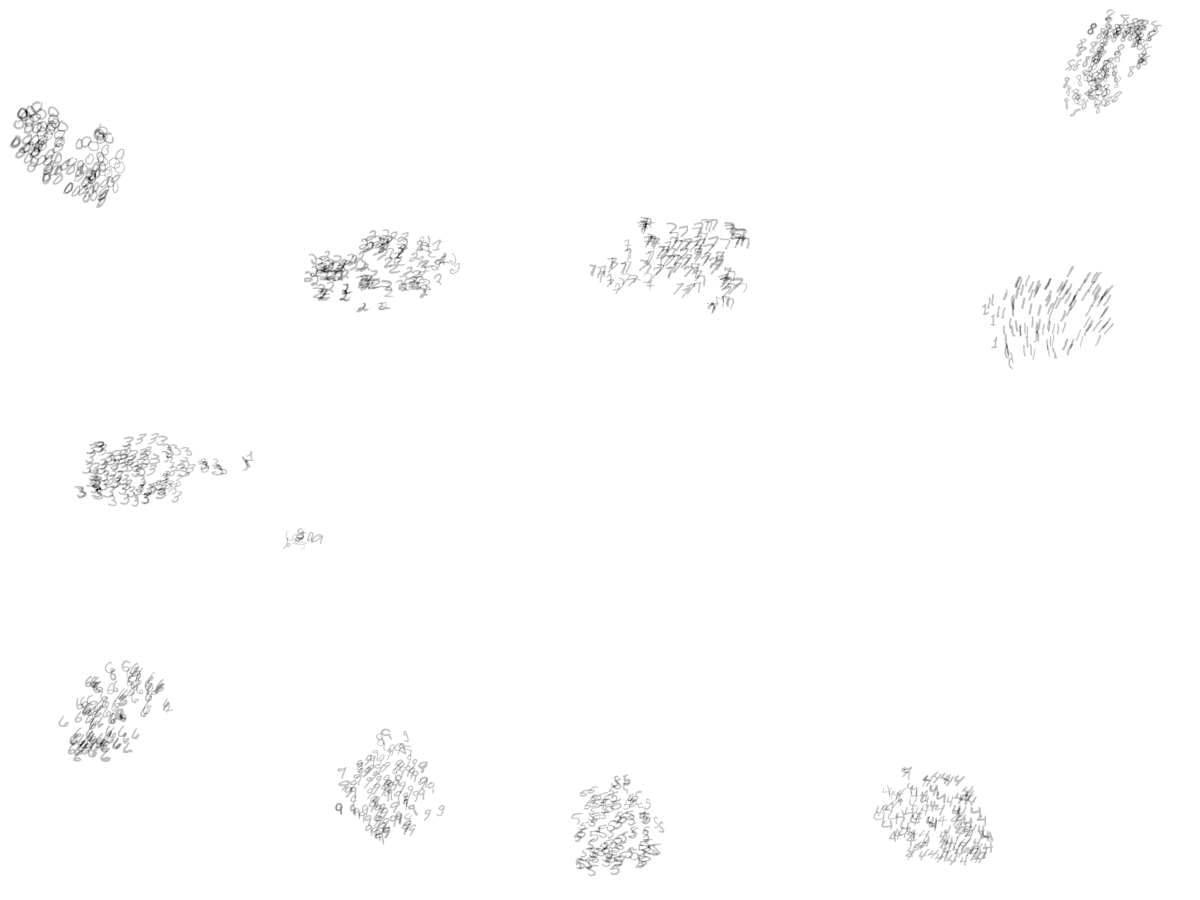

In [16]:
local images = subset

local s = {900,1200}
local b = 16
local p_ = p:clone()
local px = p_:select(2,1)
local py = p_:select(2,2)
px = (px - px:min()) / (px:max() - px:min())
py = (py - py:min()) / (py:max() - py:min())
local im = torch.FloatTensor(1,s[1],s[2]):fill(0)
for i,v in ipairs(images:split(1)) do
    local x = math.ceil(b + px[i]*s[1]*0.95)
    local y = math.ceil(b + py[i]*s[2]*0.95)
    local scaled = image.scale(v,b,b)
    im[{{},{x-b/2,x+b/2-1},{y-b/2,y+b/2-1}}]:add(scaled)
end
itorch.image(-im+1)

# Homework

As a homework you can try the following:
 * Visualize t-SNE embedding over training, started from randomly initialized network
 * Try more complicated network structure, e.g. convolutional network, LeNet
 * Experiment with different optimization methods, try ADAM or L-BFGS
 * Try out another loss function